In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Carregando os Dados
dlojas = spark.table('dlojas').toPandas()
fatovendas = spark.table('fatovendas').toPandas()
dclientes = spark.table('dclientes').toPandas()
dprodutos = spark.table('dprodutos').toPandas()

# Corrigindo tipos e criando coluna TotalValue
fatovendas['Promo'] = fatovendas['Promo'].astype(int)
fatovendas['UnitsSold'] = fatovendas['UnitsSold'].astype(float)
fatovendas['ValueSold'] = fatovendas['ValueSold'].str.replace(',', '.').astype(float)
fatovendas['TotalValue'] = fatovendas['UnitsSold'] * fatovendas['ValueSold']
fatovendas['Date'] = pd.to_datetime(fatovendas['Date'], format='%d/%m/%Y')
fatovendas['Ano'] = fatovendas['Date'].dt.year
fatovendas['Mês'] = fatovendas['Date'].dt.month_name()
fatovendas['Ano - Mês'] = fatovendas['Date'].dt.to_period('M')
fatovendas['Descrição_tipo'] = fatovendas['Descrição'].str.split(' ', n=1).str[0]

# Transformando tabela Atributos em dimensão
dprodutos = dprodutos.drop_duplicates()
dprodutos = pd.pivot_table(dprodutos, index='ProdID', columns='descricao_atributo', values='descricao_valor_atributo', aggfunc='first')

# Corrigindo UF Nulos
uf_correcao = dlojas.groupby('CodigoCidade')['UF'].agg(lambda x: x.mode()[0] if not x.mode().empty else None)
dlojas = dlojas[['StoreID', 'CodigoCidade']].merge(uf_correcao, on='CodigoCidade', how='left')

# Mesclando consultas na fato
fatovendas = fatovendas.merge(dlojas[['UF', 'StoreID']], on='StoreID', how='left')
fatovendas = fatovendas.merge(dclientes, on='CustomerID', how='left')
fatovendas = fatovendas.merge(dprodutos, on='ProdID', how='left')

print(fatovendas.columns)

Index(['TransactionID', 'Date', 'StoreID', 'ProdID', 'CustomerID', 'UnitsSold',
       'Descrição', 'Tamanho', 'Cor', 'ValueSold', 'Promo', 'TotalValue',
       'Ano', 'Mês', 'Ano - Mês', 'Descrição_tipo', 'UF', 'Genero',
       'Faixa de Idade', 'ClasseSocial', 'Cadeia Produtiva', 'Calendario',
       'Estampado', 'Fit Bottom', 'Fit Top', 'Itens Fundamentais',
       'Localização', 'Marca', 'Modelagem', 'Natureza', 'Padronagem',
       'Piramide Mercadologica', 'Produtos', 'Programa', 'Push & Pull',
       'Sazonalidade', 'Sexo', 'Tema', 'Tipo'],
      dtype='object')


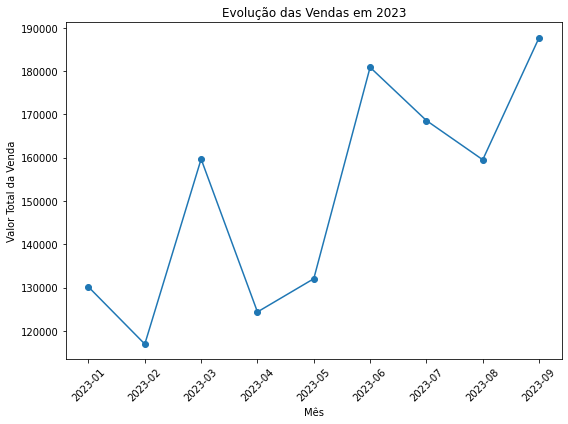

In [0]:
# 1. Como foi a evolução das vendas no ano de 2023?

df_agrupado2023 = fatovendas[fatovendas['Ano'] == 2023].groupby('Ano - Mês')['TotalValue'].sum()

plt.figure(figsize=(8, 6))
plt.title('Evolução das Vendas em 2023')
plt.xlabel('Mês')
plt.ylabel('Valor Total da Venda')
plt.plot(df_agrupado2023.index.astype(str), df_agrupado2023.values, marker='o')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

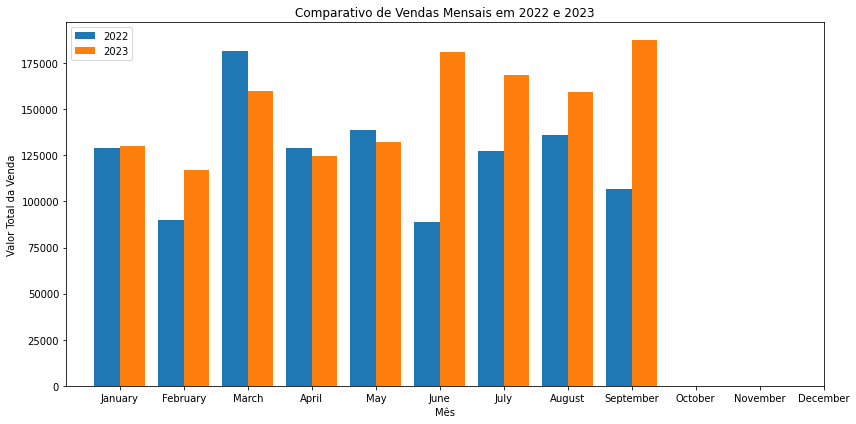

In [0]:
# 2. Como estão as vendas em relação ao ano anterior? (Analisando no geral e mês a mês)
# MoM

# Agrupando os dados
df_agrupado2022 = fatovendas[fatovendas['Ano'] == 2022].groupby('Mês')['TotalValue'].sum()
df_agrupado2023 = fatovendas[fatovendas['Ano'] == 2023].groupby('Mês')['TotalValue'].sum()

# Garantindo que os meses estejam na mesma ordem
meses = ['January', 'February', 'March', 'April', 'May', 'June', 
         'July', 'August', 'September', 'October', 'November', 'December']

# Reindexando os DataFrames para garantir a ordem correta
df_agrupado2022 = df_agrupado2022.reindex(meses)
df_agrupado2023 = df_agrupado2023.reindex(meses)


plt.figure(figsize=(12, 6))
bar_width = 0.4
index = np.arange(len(meses))  # Criando um array de índices para os meses

plt.bar(index, df_agrupado2022.values, bar_width, label='2022')
plt.bar(index + bar_width, df_agrupado2023.values, bar_width, label='2023')

plt.xlabel('Mês')
plt.ylabel('Valor Total da Venda')
plt.title('Comparativo de Vendas Mensais em 2022 e 2023')
plt.xticks(index + bar_width / 2, meses)  
plt.legend()
plt.tight_layout()
plt.show()

0.2072304257573889


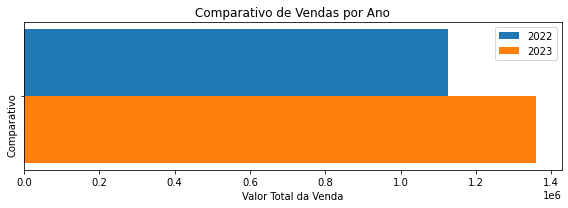

In [0]:
# 2. YoY
df_agrupado2022 = fatovendas[fatovendas['Ano'] == 2022].groupby('Ano')['TotalValue'].sum()
df_agrupado2023 = fatovendas[fatovendas['Ano'] == 2023].groupby('Ano')['TotalValue'].sum()

print((df_agrupado2023.iloc[0] - df_agrupado2022.iloc[0])/df_agrupado2022.iloc[0])

anos = ['Comparativo']
y = np.arange(len(anos))
height = 0.35

fig, ax = plt.subplots(figsize=(8, 3))
bar1 = ax.barh(y - height/2, df_agrupado2022.values, height, label='2022')
bar2 = ax.barh(y + height/2, df_agrupado2023.values, height, label='2023')

ax.set_yticks(y)
ax.set_yticklabels(anos)
plt.yticks(rotation=90, ha='right')
ax.set_xlabel('Valor Total da Venda')
ax.set_title('Comparativo de Vendas por Ano')
ax.legend()
ax.invert_yaxis()  # Para exibir 2022 acima de 2023

fig.tight_layout()
plt.show()

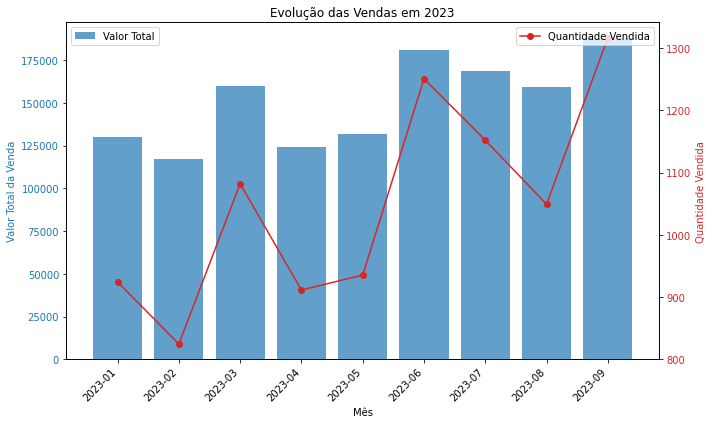

In [0]:
# 3. Quais produtos foram os mais vendidos e os mais rentáveis em 2023?
df_agrupado2023 = fatovendas[fatovendas['Ano'] == 2023].groupby('Ano - Mês')[['TotalValue', 'UnitsSold']].sum()

fig, ax1 = plt.subplots(figsize=(10, 6))

# Criar eixo principal de valor de vendas
color = 'tab:blue'
ax1.set_xlabel('Mês')
ax1.set_ylabel('Valor Total da Venda', color=color)
ax1.bar(df_agrupado2023.index.astype(str), df_agrupado2023['TotalValue'], color=color, alpha=0.7, label='Valor Total')
ax1.tick_params(axis='y', labelcolor=color)
plt.xticks(rotation=45, ha='right')

# Criar o segundo eixo para a quantidade vendida
ax2 = ax1.twinx() 
color = 'tab:red'
ax2.set_ylabel('Quantidade Vendida', color=color)
ax2.plot(df_agrupado2023.index.astype(str), df_agrupado2023['UnitsSold'], color=color, marker='o', label='Quantidade Vendida')
ax2.tick_params(axis='y', labelcolor=color)

# Título e legendas
plt.title('Evolução das Vendas em 2023')
fig.tight_layout()
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

In [0]:
# 4. Qual foi o ticket médio das vendas em 2023?

# Calculando a média ponderada
TKM23 = fatovendas[fatovendas['Ano']==2023]['TotalValue'].sum() / fatovendas[fatovendas['Ano']==2023]['UnitsSold'].sum()
print(TKM23)


143.985201694018


ClasseSocial    A    B     C    D    E
Genero                                
F             455  759  2262  763  454
M             342  143  1202  307  243
X              75    0   320   61   84


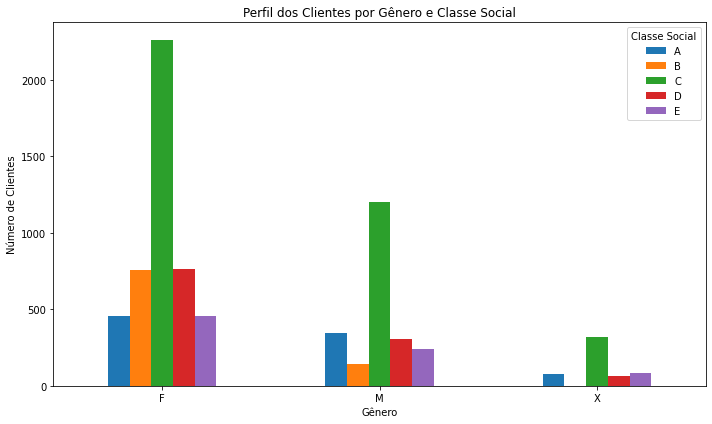

In [0]:
# 5. Para qual público vendemos mais?
df_agrupado = fatovendas.groupby(['Genero', 'ClasseSocial']).size().unstack(fill_value=0)
print(df_agrupado)

df_agrupado.plot(kind='bar', figsize=(10, 6))
plt.title('Perfil dos Clientes por Gênero e Classe Social')
plt.xlabel('Gênero')
plt.ylabel('Número de Clientes')
plt.xticks(rotation=0)
plt.legend(title='Classe Social')
plt.tight_layout()
plt.show()

Faixa de Idade
18-25     850
25-35    3890
35-45    2355
45+       690
Name: TransactionID, dtype: int64


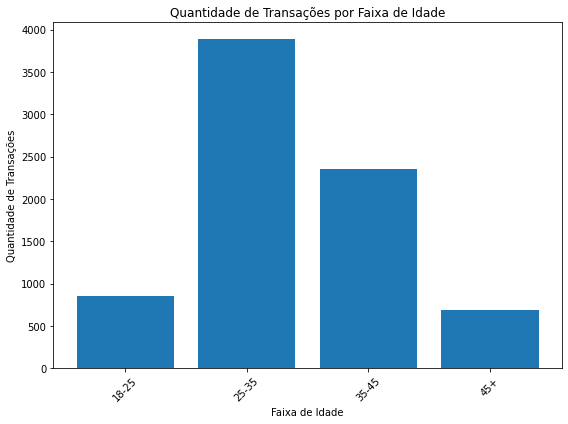

In [0]:
# 6. Qual é a faixa etária que mais compra nossos produtos?

df_agrupadoidade = fatovendas.groupby('Faixa de Idade')['TransactionID'].count()
print(df_agrupadoidade)

plt.figure(figsize=(8, 6))
plt.title('Quantidade de Transações por Faixa de Idade')
plt.xlabel('Faixa de Idade')
plt.ylabel('Quantidade de Transações')
plt.bar(df_agrupadoidade.index, df_agrupadoidade.values)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Descrição_tipo  Blusa  Calça  Camisa  Colete  Jaqueta  Regata
StoreID                                                      
Loja001         228.0  233.0   215.0   114.0     84.0   120.0
Loja002         423.0  618.0   467.0   208.0    171.0   227.0
Loja003         504.0  578.0   487.0   238.0    164.0   240.0
Loja004         437.0  459.0   518.0   262.0    168.0   240.0
Loja005         412.0  540.0   442.0   180.0    143.0   210.0
Loja006         451.0  449.0   473.0   207.0    179.0   250.0
Loja007         405.0  513.0   527.0   203.0    133.0   252.0
Loja008         383.0  574.0   455.0   216.0    150.0   223.0
Loja009         465.0  606.0   519.0   182.0    145.0   171.0
Loja010         246.0  283.0   253.0   113.0     66.0    90.0


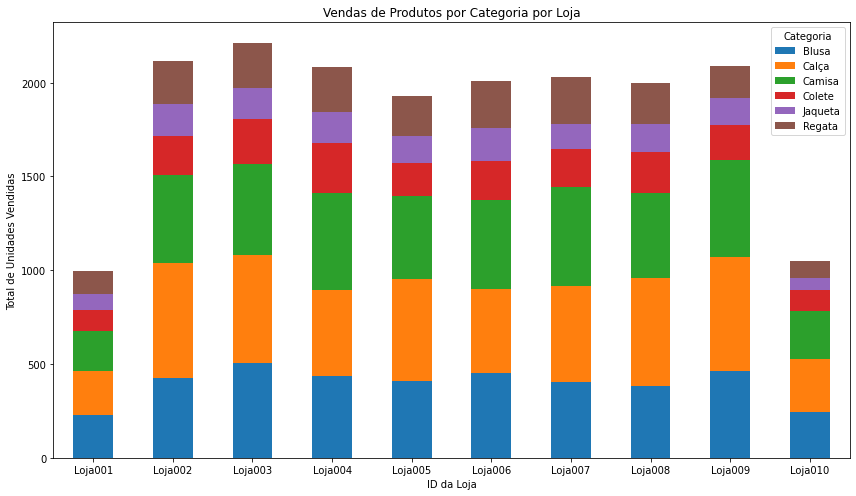

In [0]:
# 7. Qual loja vende mais produtos?
df_agrupadoprod = fatovendas.groupby(['StoreID', 'Descrição_tipo'])['UnitsSold'].sum().unstack(fill_value=0)
print(df_agrupadoprod)

df_agrupadoprod.plot(kind='bar', stacked=True, figsize=(12, 7))
plt.title('Vendas de Produtos por Categoria por Loja')
plt.xlabel('ID da Loja')
plt.ylabel('Total de Unidades Vendidas')
plt.legend(title='Categoria')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [0]:
# 8. Gere 4 insights adicionais (além dos acima) a partir de suas análises. Envolva os dados relativos aos atributos (que constam na aba "Master Atributos") em pelo menos um desses insights adicionais.


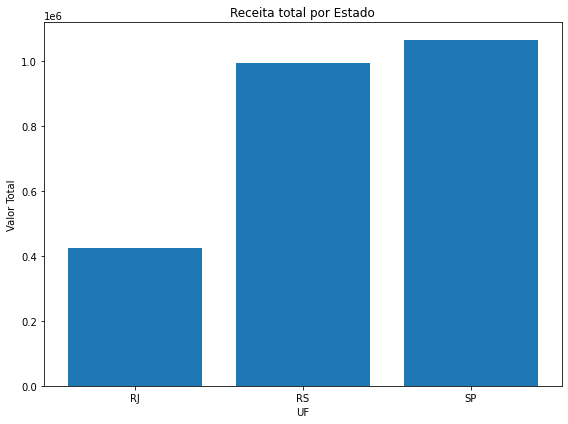

In [0]:
# a) Valor total de vendas por UF
df_agrupadoUF = fatovendas.groupby('UF')['TotalValue'].sum()

plt.figure(figsize=(8, 6))
plt.title('Receita total por Estado')
plt.xlabel('UF')
plt.ylabel('Valor Total')
plt.bar(df_agrupadoUF.index, df_agrupadoUF.values)
plt.tight_layout()
plt.show()

Sazonalidade        Meia Estacao  Produto Leve  Todas Estacoes
Calendario                                                    
1 Entrada Inverno    436672.6050   181012.9085     220790.4650
1 Entrada Verao           0.0000   339764.7400      97741.1475
2 Entrada Inverno         0.0000   309587.3935          0.0000
2 Entrada Verao      286008.7095   239312.7660     195997.9410
Todo Ano                  0.0000        0.0000     179547.5410


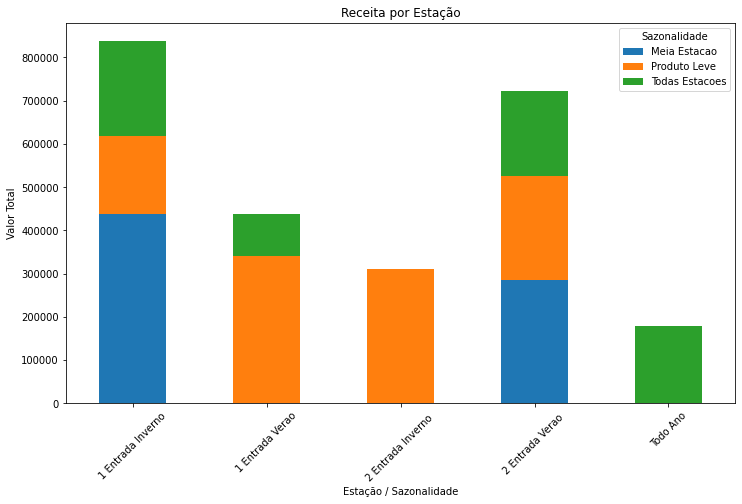

In [0]:
# b) Estação com maior faturamento
df_agrupadoSaz = fatovendas.groupby(['Calendario', 'Sazonalidade'])['TotalValue'].sum().unstack(fill_value=0)
print(df_agrupadoSaz)

df_agrupadoSaz.plot(kind='bar', stacked=True, figsize=(12, 7))
plt.title('Receita por Estação')
plt.xlabel('Estação / Sazonalidade')
plt.ylabel('Valor Total')
plt.xticks(rotation=45)
plt.show()

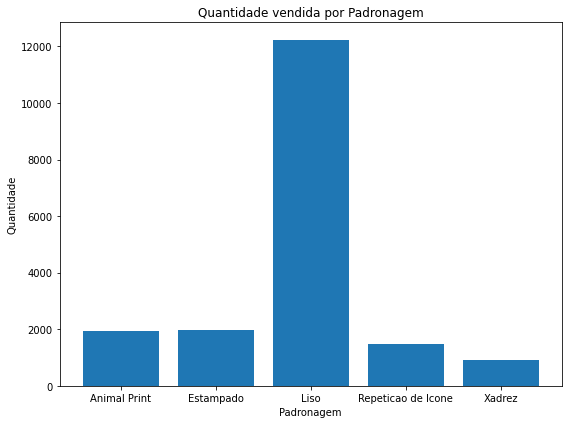

In [0]:
# c) Quantidade vendidas por Padronagem
df_agrupadoPadr = fatovendas.groupby('Padronagem')['UnitsSold'].sum()

plt.figure(figsize=(8, 6))
plt.title('Quantidade vendida por Padronagem')
plt.xlabel('Padronagem')
plt.ylabel('Quantidade')
plt.bar(df_agrupadoPadr.index, df_agrupadoPadr.values)
plt.tight_layout()
plt.show()

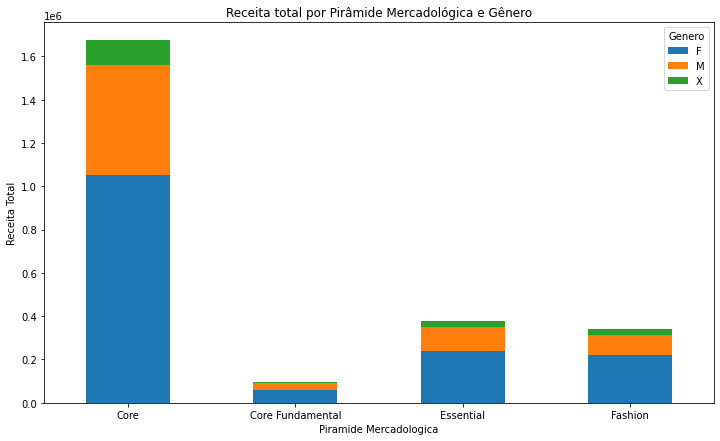

In [0]:
# d) Valor total de venda por Gêneros e Piramide Mercadologica
df_agrupadoFinal = fatovendas.groupby(['Piramide Mercadologica', 'Genero'])['TotalValue'].sum().unstack(fill_value=0)

df_agrupadoFinal.plot(kind='bar', stacked=True, figsize=(12, 7))
plt.title('Receita total por Pirâmide Mercadológica e Gênero')
plt.ylabel('Receita Total')
plt.xticks(rotation=0)
plt.show()